In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *
from training_func import *
import pyreadr
from sklearn.preprocessing import StandardScaler

In [2]:
torch.cuda.is_available()

False

In [2]:
G_21_index = False
abcd_index = True
if G_21_index:
    G_21 = xr.open_dataset("../../../Desktop/OneDrive/Desktop/CURRENT_RESEARCH/Latent_mixture/data/G_21_subset_imputed.nc")
    ABCD_sub = G_21.to_array().values.squeeze(0)
    freq_snp = ABCD_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    ABCD_sub = (ABCD_sub-2*freq_snp)/sd_snp
elif abcd_index:
    ABCD = pd.read_csv('../dataset/abcd.csv')
    list_ROI = pyreadr.read_r('../dataset/ABCD_ROI.list.RData')
    # 'rsmri_list', 'tfmri_list', 'smri_list', 'dti_list', 'rsi_list'
    ABCD_sub = ABCD.loc[:,np.isin(ABCD.columns,list(np.squeeze(list_ROI['tfmri_list'].values,1))+['subjectid', 'eventname', 'demo_rel_family_id.bl'])]
    ABCD_sub = ABCD_sub.loc[~ABCD_sub.isnull().any(axis = 1),:]
    ABCD_sub = ABCD_sub.groupby('demo_rel_family_id.bl', group_keys=False).apply(lambda x: x.sample(1, random_state = 1)).reset_index(drop=True)
    ABCD_sub = ABCD_sub.groupby(['subjectid',"eventname"],group_keys=False).apply(lambda x: x.sample(1, random_state = 1)).reset_index(drop=True)
    ABCD_sub = ABCD_sub.loc[:,np.isin(ABCD_sub.columns,list(np.squeeze(list_ROI['tfmri_list'].values,1)))]
    scaler = StandardScaler()
    scaler.fit(ABCD_sub)
    ABCD_sub = scaler.transform(ABCD_sub)
else:
    from pandas_plink import read_plink1_bin, Chunk
    # read the 
    unrel_subj = pd.read_table("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated_pcair_unrels.txt", header = None)
    snp_prune = pd.read_table("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated_prunned.snps", header = None)
    ABCD_full = read_plink1_bin("../../../Desktop/CURRENT_RESEARCH/Latent_mixture/data/ABCD_20220428.updated.nodups.curated.bed",
                          chunk=Chunk(nsamples=100, nvariants=None))
    ABCD_full = ABCD_full.where(ABCD_full.sample.isin(unrel_subj.to_numpy().squeeze(1)), drop=True)
    #ABCD_full.where(ABCD_full.variant.isin(snp_prune.to_numpy().squeeze(1)), drop=True)
    freq_snp = ABCD_full.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    # a subset that have variability in the SNPs
    ABCD_sub = ABCD_full[:,~sd_snp.isin(0)]
    freq_snp = ABCD_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    ABCD_sub = (ABCD_sub-2*freq_snp)/sd_snp
    ABCD_sub.persist()
    ABCD_sub =  ABCD_sub.values
    ABCD_sub[np.isnan(ABCD_sub)]=0


/var/folders/cy/7rpv9wdx3nb25gzbj78xgqwm0000gn/T/ipykernel_2489/123490829.py:10: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ABCD = pd.read_csv('../dataset/abcd.csv')


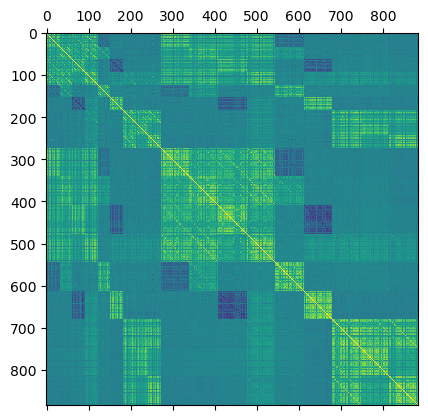

In [21]:
import matplotlib.pyplot as plt
plt.matshow(pd.DataFrame(ABCD_sub).corr())
plt.show()

In [4]:
ABCD_sub.shape

(9579, 1186)

In [3]:
real_data_index = True
max_n_p = True
# n = 6000
# p = 500
#p_confound = 0

n = ABCD_sub.shape[0]
p_confound = 0
p = ABCD_sub.shape[1]-p_confound
p_causal = int(p*0.1)
beta_var = 0.1
#p_causal = int(n*0.1)
batch_size = n
r_batch = batch_size/n
device = 'cpu'
if real_data_index:
    if not max_n_p:
        np.random.seed(seed = None)
        p_max = ABCD_sub.shape[1]
        n_max = ABCD_sub.shape[0]
        SNP_index = np.random.choice(p_max,size = p, replace = False)
        subject_index =  np.random.choice(n_max,size = n, replace = False)
        ABCD_sub_sub = ABCD_sub[np.ix_(subject_index, SNP_index)]
        print(ABCD_sub_sub.shape)
        Xs = [ABCD_sub_sub]
    else:
        Xs = [ABCD_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None
print(r_batch)

1.0


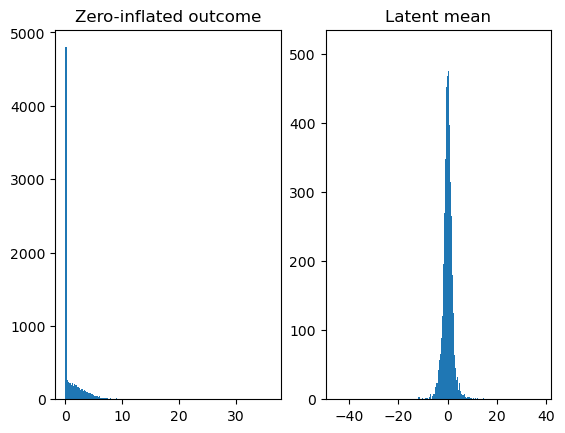

------------------------------------
genetic variance is 6.107177057893581
total variance is12.214354115787161
heritability is 0.5
------------------------------------


In [4]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.5
beta_bias = 0
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal,p_confound = p_confound, rho = rho, var = var,
                                    n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None, beta_var= beta_var)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)
if p_confound >0:
    true_beta_confound = true_beta[:p_confound]
    true_beta = true_beta[p_confound:]

In [5]:
exact_lh = True
tobit_data = True
tobit_model = True
if tobit_data:
    y_star = z
from sklearn.model_selection import train_test_split
X_train, X_test, z_train, z_test = train_test_split(X, y_star, test_size=0.2, random_state=42)

In [6]:
sim_data = Sim_Dataset(torch.tensor(X_train).float(),torch.tensor(z_train).float(), device = device)
sim_data_loader = DataLoader(sim_data, batch_size = batch_size)
model = linear_slab_spike(p = p, n_total = n, p_confound = p_confound, init_pi_local_max = 1.0, init_pi_local_min = 0.0,init_pi_global = 0.5, init_beta_var =1, init_noise_var = 1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = False, 
                          a1= 0.1, a2=0.1, init_a3= 1.1, init_a4 = 1.1,
                          b1 = 1.1, b2 = 1.1, init_b3 = 10.0, init_b4 = 0.1, n_E = 1
                          , prior_sparsity = True, prior_sparsity_beta = False,exact_lh = exact_lh,tobit = tobit_model, device = device
                         ).double().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.1)

At iteration 0, the loss is 21478.927381742935


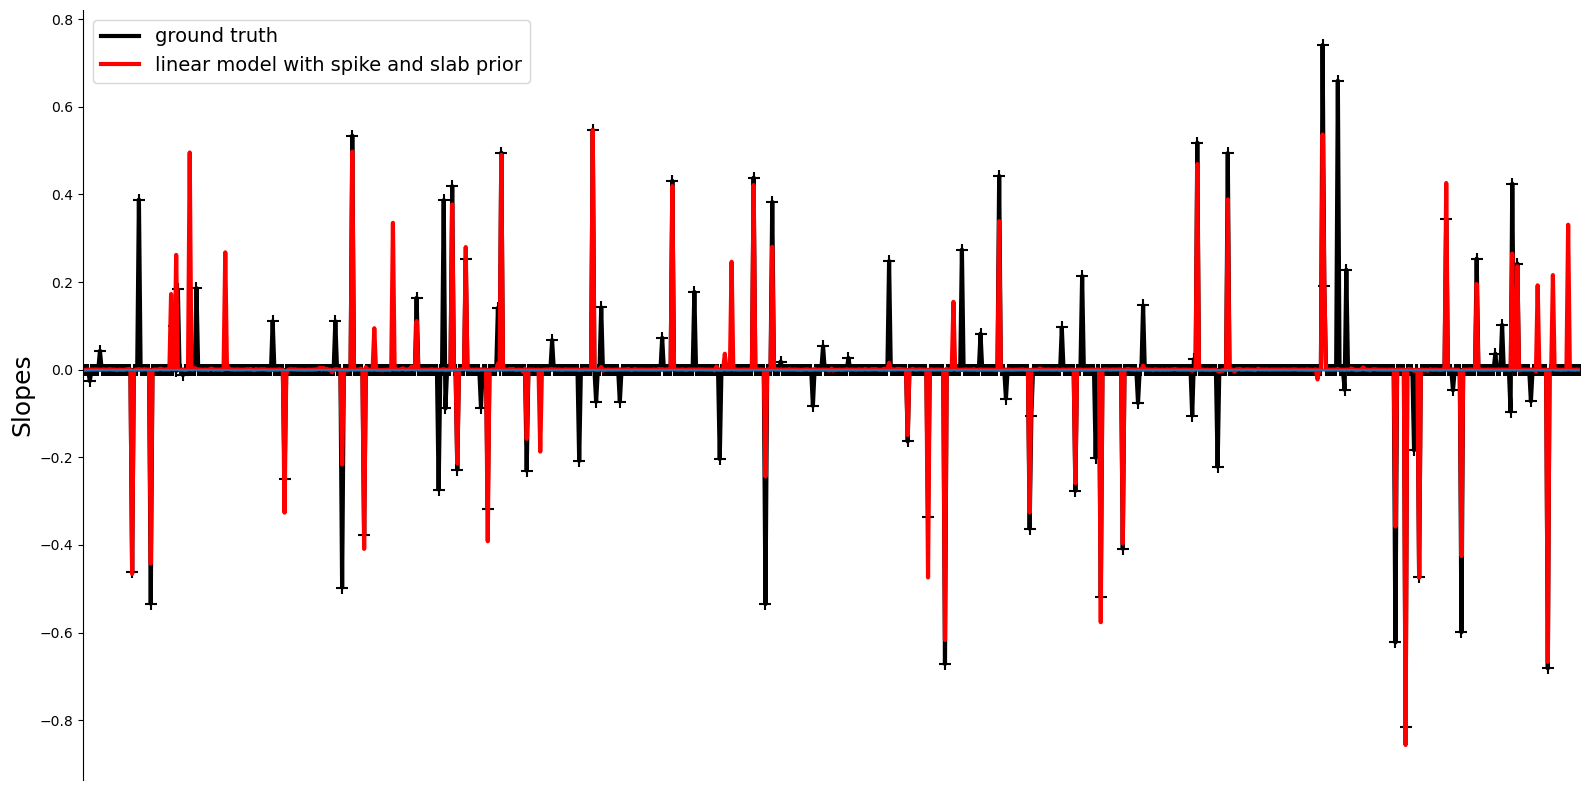

In [7]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
t = 100 #number of moving averages
patience = 100# patience
best_model, error, point_est, result_dict = train_and_infer(model = model, optimizer = optimizer, sim_data_loader = sim_data_loader, lr_scheduler = lr_scheduler, t = t, patience = patience,X = X, plot = True, true_beta = true_beta, verbose = True)

In [8]:
result_dict

{'mean_h_est': [0.49046683717567896],
 'h_est_upper': [0.5442916516172303],
 'h_est_lower': [0.4366493664397473],
 'mean_var_genetic': [6.039293573123421],
 'noise_var': [6.29906295925756],
 'global_pi': [0.07586552365485913],
 'global_pi_upper': [0.11468090929598922],
 'global_pi_lower': [0.045386366442114],
 'FDR': 0.09090909090909091,
 'sensitivity': 0.3409090909090909}

In [19]:
p_causal/p

0.09949409780775717

In [10]:
from sklearn.linear_model import LassoCV,RidgeCV
# Lasso
reg = LassoCV(cv = 5, alphas = (0.001,0.01,0.1,1,10), max_iter=10000)
reg.fit(X_train,z_train)
z_pred = reg.predict(X_test)
mse_lasso = np.mean(np.abs(z_pred*(z_pred>0)-z_test))
z_pred_train = reg.predict(X_train)
residuals = z_train-z_pred_train
sigma_squared_hat = np.var(residuals)
var_g = np.var(z_pred_train)
h_lasso = var_g/(sigma_squared_hat+var_g)
# Ridge
reg = RidgeCV(cv = 5, alphas = (0.001,0.01,0.1,1,10))
reg.fit(X_train,z_train)
z_pred = reg.predict(X_test)
mse_ridge = np.mean(np.abs(z_pred*(z_pred>0)-z_test))
z_pred_train = reg.predict(X_train)
residuals = z_train-z_pred_train
sigma_squared_hat = np.var(residuals)
var_g = np.var(z_pred_train)
h_ridge = var_g/(sigma_squared_hat+var_g)

In [13]:
z_pred = best_model.predict(torch.tensor(X_test).float())
mse = np.mean(np.abs(z_pred*(z_pred>0) - z_test))
print(mse)
print(mse_lasso)
print(mse_ridge)
print(h_lasso)
print(h_ridge)

0.9717139627373169
1.1730793246889417
1.1911104370305028
0.39390328530704954
0.46784514590824994


[4.76665277]
[0.00044361]
117.68286336572353


(array([  6.,  42., 175., 271., 295., 164.,  41.,   5.,   0.,   1.]),
 array([109.58064255, 111.59354532, 113.60644808, 115.61935085,
        117.63225361, 119.64515638, 121.65805914, 123.6709619 ,
        125.68386467, 127.69676743, 129.7096702 ]),
 <BarContainer object of 10 artists>)

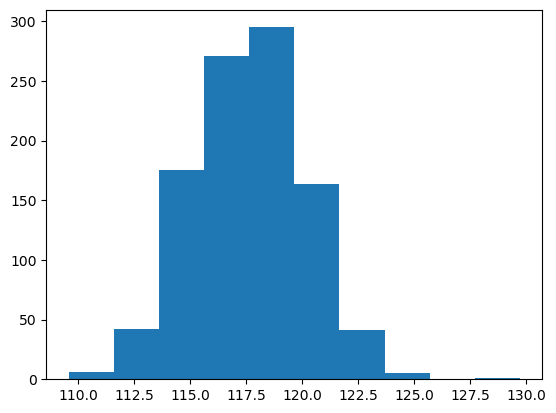

In [248]:
b3 = best_model.b3.cpu().detach().numpy()
b4 = np.exp(best_model.log_b4.cpu().detach().numpy())
print(b3)
print(b4)
# Noise variance posterior
noise_var_poster = np.exp(np.random.normal(b3,np.sqrt(b4), size = (1000,)))
noise_var_est = np.median(noise_var_poster)
print(noise_var_est)
plt.hist(noise_var_poster)

[11.30421813]
[82.16520015]


(array([ 20.,  88., 209., 264., 195., 135.,  54.,  24.,   9.,   2.]),
 array([0.04039619, 0.0615246 , 0.08265301, 0.10378142, 0.12490983,
        0.14603824, 0.16716665, 0.18829507, 0.20942348, 0.23055189,
        0.2516803 ]),
 <BarContainer object of 10 artists>)

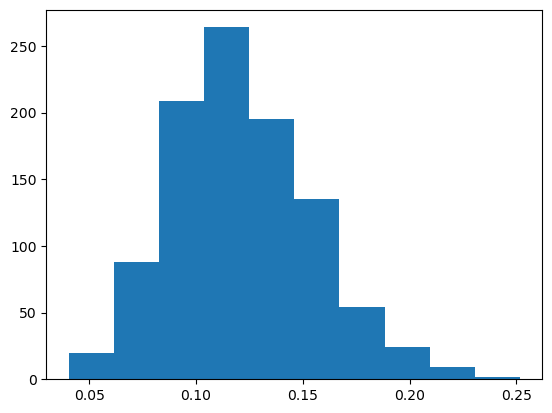

In [249]:
a3 = torch.exp(best_model.log_a3).cpu().detach().numpy()
a4 = torch.exp(best_model.log_a4).cpu().detach().numpy()
print(a3)
print(a4)
global_pi_poster = np.random.beta(a3,a4, size = (1000,))
plt.hist(global_pi_poster)

[149 145 146 ... 152 145 149]
[1039 1043 1042 ... 1036 1043 1039]
0.14375150566828887
0.09282949887584889


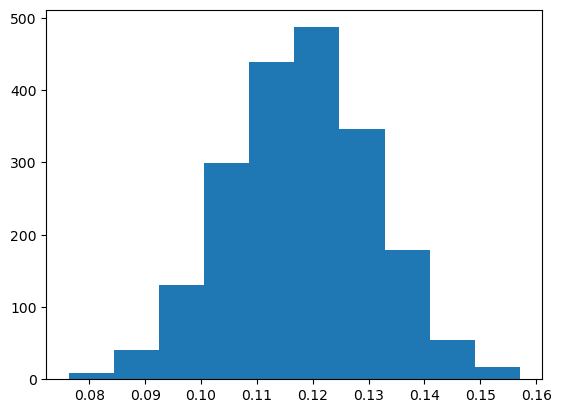

In [250]:
m = np.sum(np.random.binomial(n= 1, p = torch.sigmoid(best_model.logit_pi_local).detach().cpu().numpy(), size = (2000, p)), axis = 1)
a3 = m+1
a4 = p-m+1
print(a3)
print(a4)
global_pi_poster = np.random.beta(a3,a4)
plt.hist(global_pi_poster)
global_pi_upper = np.quantile(global_pi_poster, q = 0.975)
global_pi_lower = np.quantile(global_pi_poster, q = 0.025)
print(global_pi_upper)
print(global_pi_lower)

In [120]:
np.sum(torch.sigmoid(best_model.logit_pi_local).detach().cpu().numpy()>0.5)

45

In [121]:
pi_VI = torch.sigmoid(best_model.logit_pi_local).detach().numpy()

In [122]:
# torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p
print(torch.max(torch.sigmoid(best_model.logit_pi_local)))
print(torch.min(torch.sigmoid(best_model.logit_pi_local)))
print(torch.mean(torch.sigmoid(best_model.logit_pi_local)))
# torch.min(model.beta_mu)
# torch.max(model.beta_mu)
torch.exp(best_model_.beta_log_var)
print(torch.mean(torch.exp(best_model.beta_log_var)))

tensor(0.9998, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0131, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor(0.0692, dtype=torch.float64, grad_fn=<MeanBackward0>)


NameError: name 'best_model_' is not defined

In [ ]:
# c = torch.exp(best_model.log_c).detach().numpy()
# d = torch.exp(best_model.log_d).detach().numpy()
# # c = 10
# # d = 10
# print(c)
# print(d)
# posterior = np.random.beta(c,d,size = (5000,))
# np.median(posterior)
# print(np.quantile(posterior, q = 0.025))
# print(np.quantile(posterior, q = 0.975))
# plt.hist(posterior)
# plt.show()

# MCMC algorithm

In [73]:
from mcmc_linear import experiment, linear_mcmc_model, tobit_mcmc_model
import jax.numpy as jnp

def comparison_plot(est, true):
    p = len(true)
    fig = plt.figure(figsize=(16,8), facecolor='white')
    ax = fig.add_subplot(1,1,1)
    ax.plot(np.arange(p), true, \
           linewidth = 3, color = "black", label = "ground truth")
    ax.scatter(np.arange(p), true, \
           s = 70, marker = '+', color = "black")
    ax.plot(np.arange(p),  est, \
               linewidth = 3, color = "red", \
               label = "linear model with spike and slab prior")
    ax.set_xlim([0,p-1])
    ax.set_ylabel("Slopes", fontsize=18)
    ax.hlines(0,0,p-1)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.legend(prop={'size':14})
    fig.set_tight_layout(True)
    plt.show()




In [75]:
if tobit_model:
    model_mcmc = tobit_mcmc_model
else:
    model_mcmc = linear_mcmc_model
exp = experiment(model_mcmc, y_star.numpy(), X.numpy())
exp.train(step_size =1,verbose = True)
heritability, genetic_var, data_var = exp.cal_heritability()

warmup:   4%| | 45/1200 [02:34<1:06:08,  3.44s/it, 511 steps of size 3.30e-03. a

KeyboardInterrupt



In [1050]:
posterior = exp.mcmc.get_samples()
beta = posterior["beta"]* posterior["delta"]
g_var = (beta @ jnp.transpose(X.numpy()) ).var(axis = 1)
dat_var = posterior["var_error"]
heritability = g_var/(dat_var+g_var)
print('point estimate of heritability: '+ str(np.mean(heritability)))
print('lower bound of heritability: '+ str(np.quantile(heritability, 0.025)))
print('upper bound of heritability: '+ str(np.quantile(heritability, 0.975)))
print('point estimate of p_causal: '+ str(np.mean(exp.mcmc.get_samples()['pi'], axis = 0)))
print('lower bound of p_causal: '+ str(np.quantile(exp.mcmc.get_samples()['pi'], 0.025)))
print('upper bound of p_causal: '+ str(np.quantile(exp.mcmc.get_samples()['pi'], 0.975)))

point estimate of heritability: 0.29591173
lower bound of heritability: 0.23698055744171143
upper bound of heritability: 0.3560153514146805
point estimate of p_causal: 0.575814
lower bound of p_causal: 0.26115741953253746
upper bound of p_causal: 0.8787699803709983


0.097488806
0.42100003
0.975
0.54700005


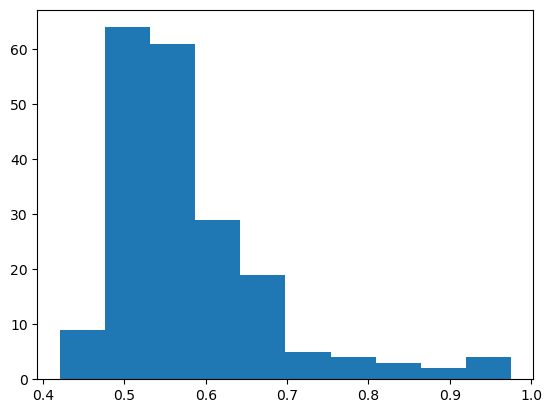

In [1051]:
pi_mcmc = np.mean(posterior["delta"], axis = 0)
plt.hist(pi_mcmc)
print(np.std(pi_mcmc))
print(np.min(pi_mcmc))
print(np.max(pi_mcmc))
print(np.median(pi_mcmc))

0.05620831782021683
0.6715337197516003
0.9677201371593954
0.7238340471948959


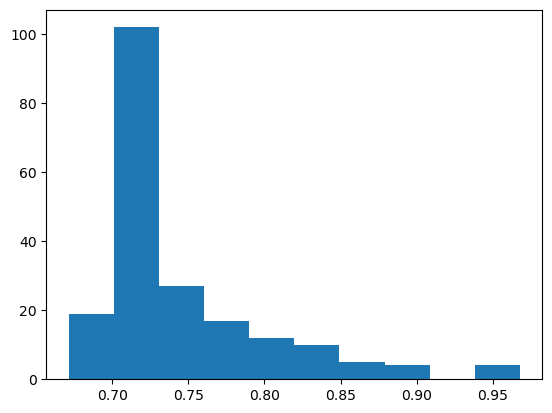

In [1052]:
plt.hist(pi_VI)
print(np.std(pi_VI))
print(np.min(pi_VI))
print(np.max(pi_VI))
print(np.median(pi_VI))

In [1053]:
print(np.where(pi_VI>0.3))
print(pi_VI[np.where(pi_mcmc>0.3)])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [1054]:
pi_mcmc[np.where(pi_mcmc>0.3)]

Array([0.586     , 0.531     , 0.59000003, 0.48800004, 0.809     ,
       0.48600003, 0.58900005, 0.42800003, 0.49600002, 0.975     ,
       0.559     , 0.54      , 0.632     , 0.51000005, 0.70000005,
       0.68100005, 0.563     , 0.665     , 0.754     , 0.48200002,
       0.59800005, 0.503     , 0.535     , 0.597     , 0.512     ,
       0.94600004, 0.55      , 0.76000005, 0.514     , 0.469     ,
       0.455     , 0.56200004, 0.54700005, 0.54      , 0.54700005,
       0.62200004, 0.56100005, 0.559     , 0.66700006, 0.648     ,
       0.711     , 0.48000002, 0.60800004, 0.45200002, 0.568     ,
       0.513     , 0.64900005, 0.537     , 0.569     , 0.549     ,
       0.53300005, 0.53400004, 0.54300004, 0.526     , 0.54300004,
       0.592     , 0.615     , 0.615     , 0.96400005, 0.499     ,
       0.65500003, 0.54      , 0.57500005, 0.503     , 0.49800003,
       0.564     , 0.51900005, 0.559     , 0.42100003, 0.52900004,
       0.545     , 0.57900006, 0.57000005, 0.54300004, 0.504  

In [1055]:
beta_mcmc = np.mean(posterior["beta"], axis = 0)
beta_VI = best_model.beta_mu.detach().numpy()

In [1056]:
print(beta_VI[np.where(beta_mcmc>0.5)])
print(beta_mcmc[np.where(beta_mcmc>0.5)])
print(pi_VI[np.where(beta_mcmc>0.5)])
print(pi_mcmc[np.where(beta_mcmc>0.5)])

[0.77817326 0.51447922 0.4786649  0.32166321 0.45124475 0.49437558
 0.77227787 0.3965898  0.42780703 0.3035953  0.35102431 0.71825603
 0.47114507 0.47542686 0.35284273 0.6262013  0.4807755  0.36165447
 0.37968488 0.27197237 0.5596965 ]
[1.5423496  0.50754374 0.62195504 0.6579898  0.50332624 0.55047184
 1.4172225  0.5230825  0.5528085  0.65801114 0.5340482  1.172358
 0.5689718  0.89907855 0.6615522  0.7740907  0.55621177 0.51816505
 0.5004488  0.50514066 1.1143078 ]
[0.96261287 0.87971268 0.85047732 0.77939295 0.84102239 0.85752861
 0.96772014 0.81519935 0.83473096 0.77608007 0.79430535 0.94665459
 0.85462989 0.84953699 0.79520299 0.90799021 0.84860821 0.79631248
 0.80368333 0.756312   0.8838175 ]
[0.975      0.70000005 0.754      0.76000005 0.66700006 0.711
 0.96400005 0.68700004 0.707      0.77400005 0.702      0.95400006
 0.702      0.81900007 0.76900005 0.814      0.697      0.689
 0.697      0.666      0.919     ]


In [1057]:
print(beta_VI[np.where(beta_VI>0.5)])
print(beta_mcmc[np.where(beta_VI>0.5)])

[0.77817326 0.51447922 0.77227787 0.71825603 0.6262013  0.5596965 ]
[1.5423496  0.50754374 1.4172225  1.172358   0.7740907  1.1143078 ]


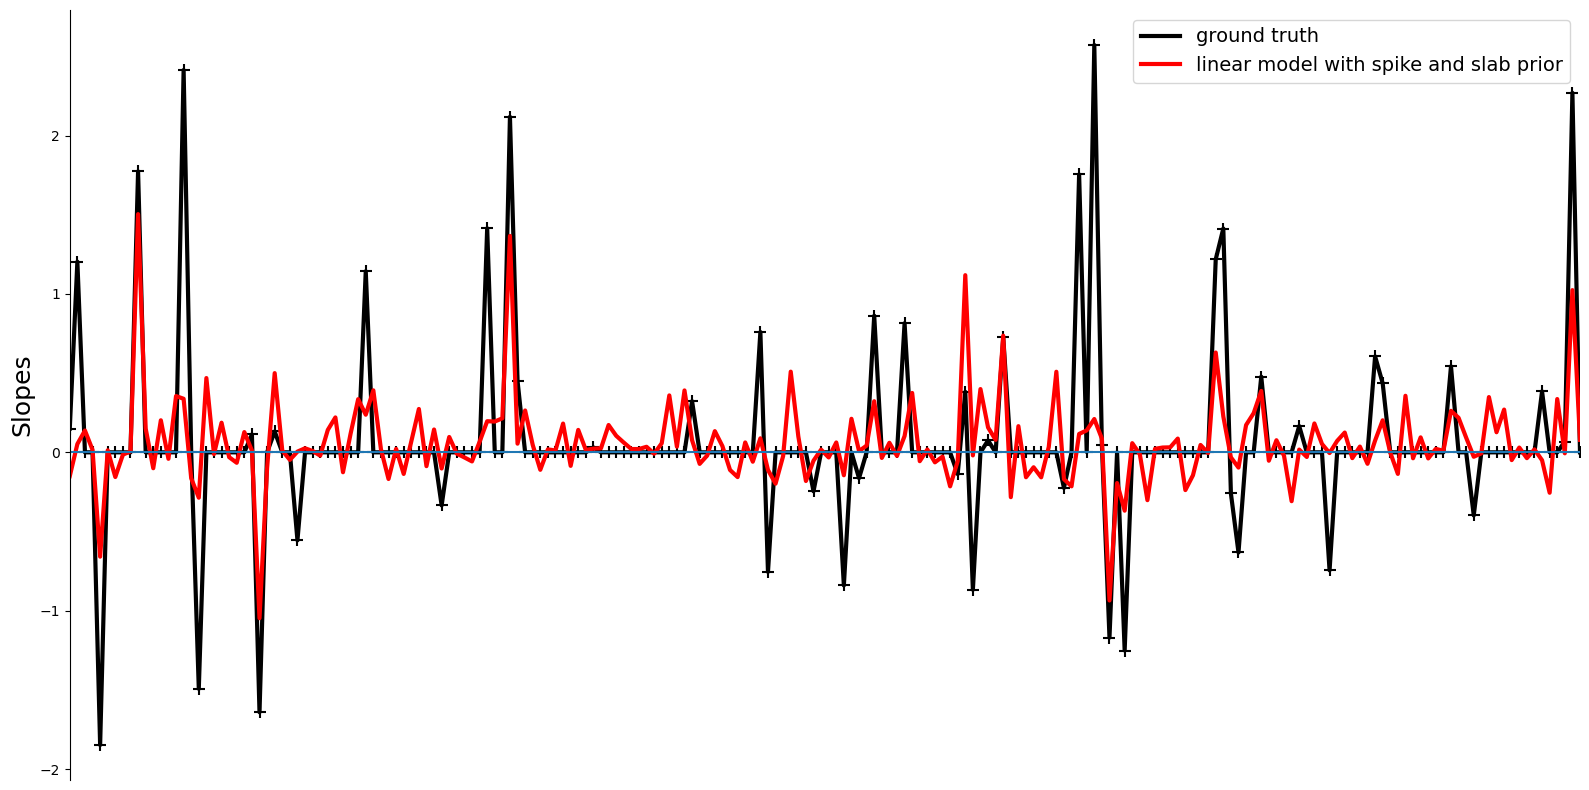

In [1058]:
comparison_plot(beta_mcmc*pi_mcmc, true_beta)

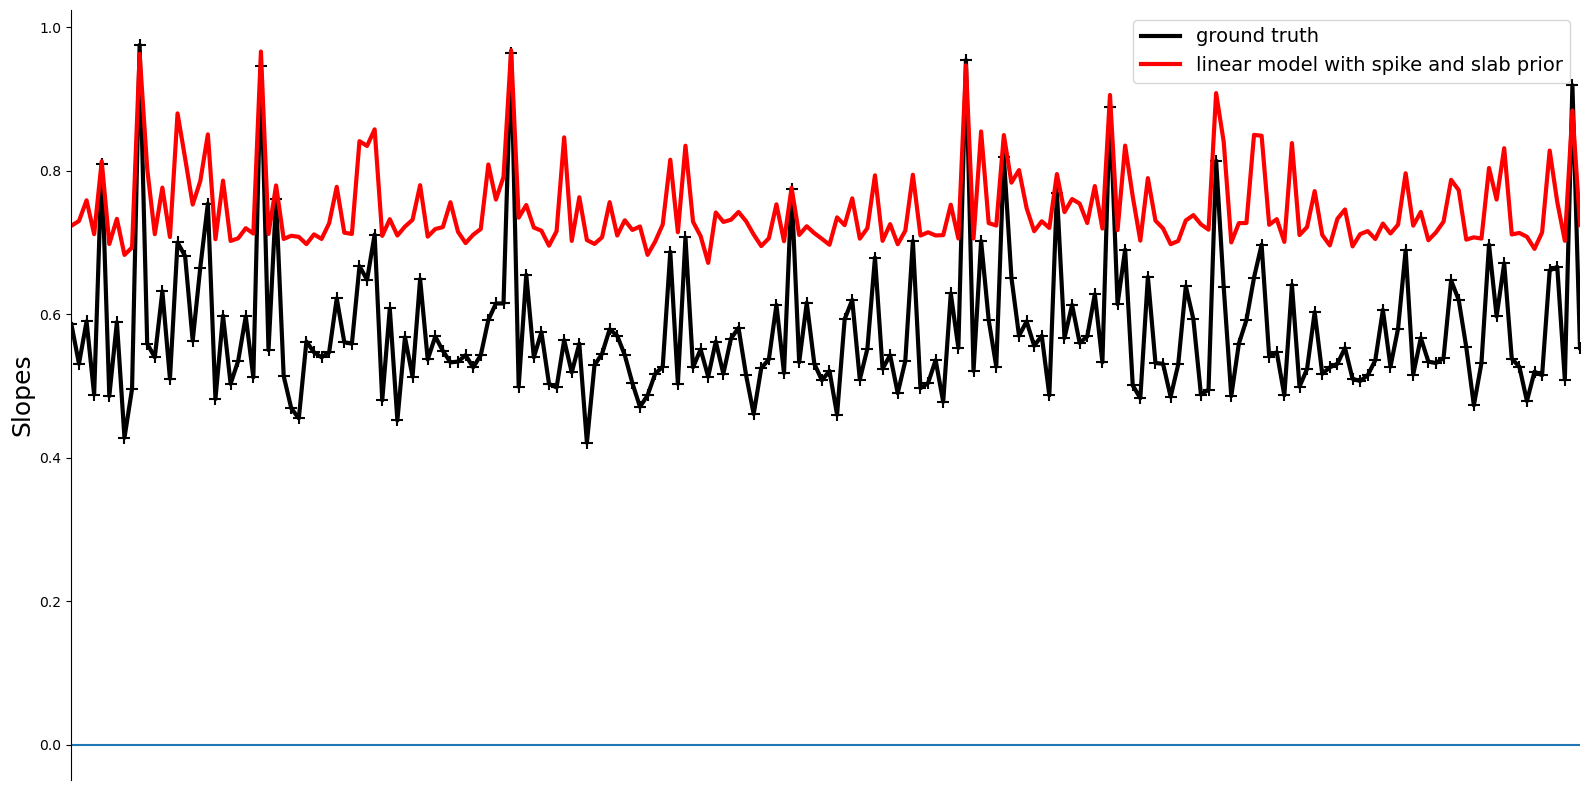

In [1059]:
comparison_plot(pi_VI, pi_mcmc)

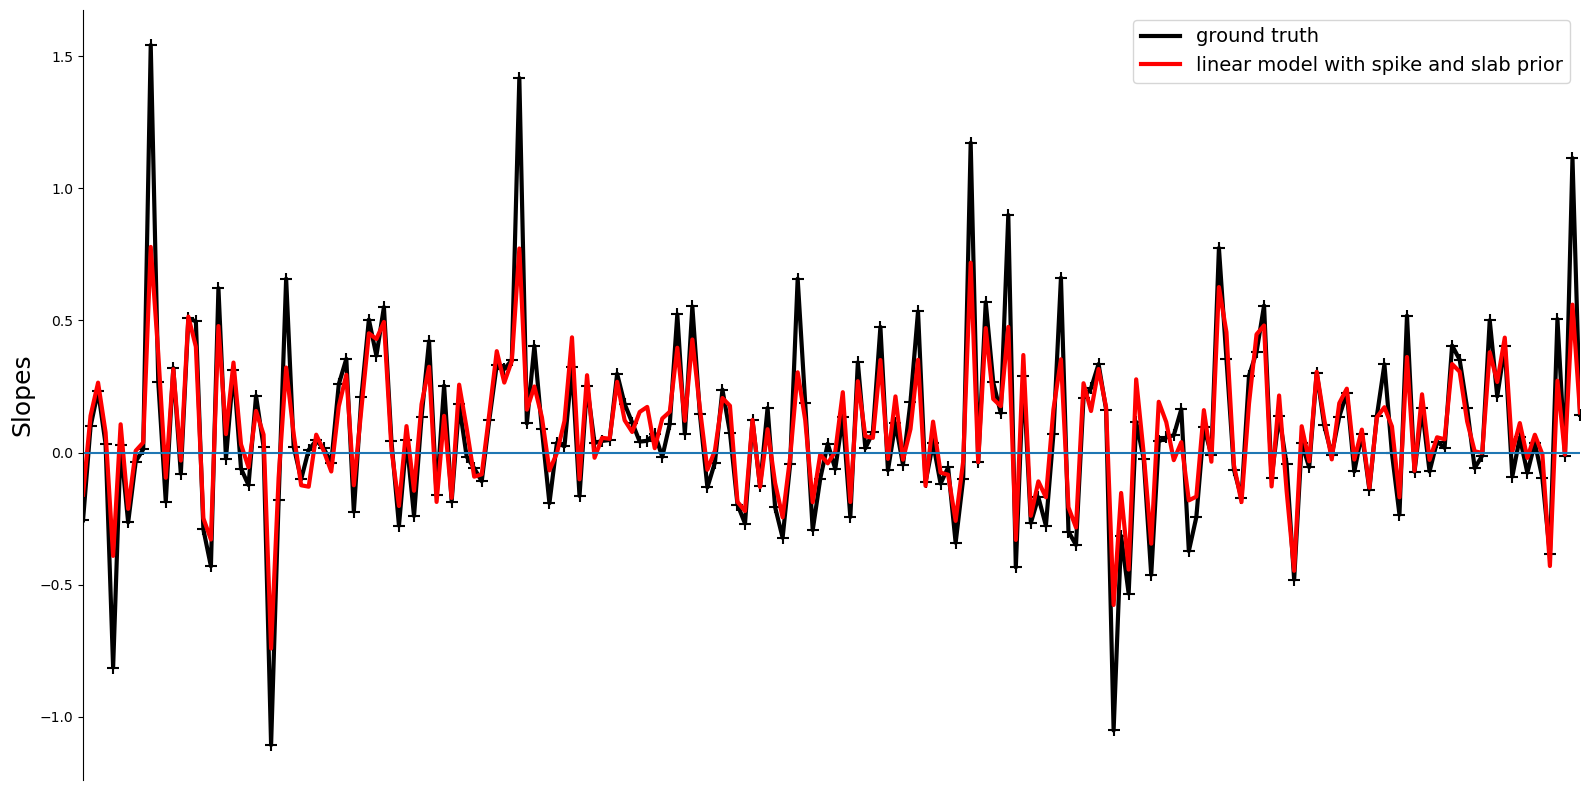

In [1060]:
comparison_plot(beta_VI, beta_mcmc)

# Pyro model

In [105]:
from pyro_model import experiment, get_guide, get_model, spike_slab_model
if device=='cuda':
    use_gpu = True
else:
    use_gpu = False
model = get_model(spike_slab_model, relaxed = True, straight_through =False, temp = 1)
#guide_type: character, 'low_rank_normal', 'diag_normal', 'custom', 'custom_delta'
guide = get_guide(model, guide_type = 'low_rank_normal', relaxed = True, straight_through = False, temp = 1, p = p)
exp = experiment(1e-2, y_star, X, model, guide, mcmc_index = False,
                 schedule_exp = 0.95, n_epoch = 10000, total_patience = 400,num_particles = 1, use_gpu = use_gpu)
exp.init_model()
exp.train(verbose = True)
est, std, lower, upper,parameter_est= exp.cal_heritability(num_samples = 1000)
exp.plot_betas(true_beta)
#print(parameter_est)
#print(true_beta)
print(est)

8631292.291831732
25642.615708589554
12252.233508944511
11177.728044390678
10124.875401377678
10531.222960829735
11363.083982110023
9380.89814710617
9020.54321718216
9996.054231286049
9211.005390048027
9132.06328701973
8167.065969824791
7760.771025776863
7668.7206835746765
7418.258573770523
6796.994118511677
6275.541908383369
5475.480432987213
4760.707949876785
4166.070843458176
3354.9896956682205
2730.8438131809235
2235.077250123024



KeyboardInterrupt



In [25]:
p

200